In [1]:
import asyncio

### CIViC data exploration

Perform basic crawl through CIViC drug items to see if TheraPy considers any of them to be redundant

In [2]:
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
transport = AIOHTTPTransport(url="https://civicdb.org/api/graphql")
client = Client(transport=transport, fetch_schema_from_transport=True)

query = gql(
    """
query getAllDrugs($cursor: String!) {
  drugs(first: 50, after: $cursor) {
    edges {
      cursor,
      node {
        id,
        name,
        ncitId
      }
    }
  }
}
"""
)

In [3]:
async def explore_civic():
    drugs = set()
    params = {"cursor": ""}
    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        while True:
            result = await session.execute(query, variable_values=params)
            for drug in result["drugs"]["edges"]:
                drugs.add(drug["node"]["name"])
            if len(result["drugs"]["edges"]) == 0:
                break
            params["cursor"] = result["drugs"]["edges"][-1]["cursor"]
    return drugs
            
drugs = await explore_civic()

In [4]:
from therapy.query import QueryHandler
q = QueryHandler()

***Using Therapy Database Endpoint: http://localhost:8000***


/Users/jss009/code/cgc-2022-therapy/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [5]:
normalized_drugs = {}
for drug in drugs:
    try:
        therapy_id = q.normalize(drug).therapy_descriptor.therapy_id
    except AttributeError as e:
        continue
    if therapy_id in normalized_drugs:
        print(f"normalized under {therapy_id}:")
        print(normalized_drugs[therapy_id])
        print(drug)
        print()
    else:
        normalized_drugs[therapy_id] = drug

normalized under rxcui:282388:
Imatinib Mesylate
Imatinib

normalized under rxcui:1100071:
Abiraterone Acetate
Abiraterone



## Normalization of external knowledgebases

### GDSC

In [6]:
import csv

# use the "csv" link for export -- not the "download" button
# downloaded 2022/07/09
# https://www.cancerrxgene.org/downloads/drug_data?screening_set=GDSC1
gdsc_1_drugs = csv.DictReader(open("gdsc-drugs-1.csv", "r"))  
gdsc_2_drugs = csv.DictReader(open("gdsc-drugs-2.csv", "r"))

normalized_dict = {}

total_compounds = 0
normalized_compounds = 0
for dataset in (gdsc_1_drugs, gdsc_2_drugs):
    for row in dataset:
        total_compounds += 1
        normalized = False
        if q.normalize(row["drug_name"]).match_type > 0:
            normalized = True
        for synonym in row["synonyms"].split(","):
            if q.normalize(synonym).match_type > 0:
                normalized = True
        if normalized:
            normalized_compounds += 1
            normalized_dict[int(row["drug_id"])] = True
        else:
            normalized_dict[int(row["drug_id"])] = False

gdsc_normalization_rate = normalized_compounds / total_compounds

### CIViC

In [7]:
from civicpy import civic

civic.load_cache(on_stale='ignore')
civic_evidence = civic.get_all_evidence()

ev_total = 0
normalized_ev_total = 0

for ev in civic_evidence:
    ev_dict = vars(ev)
    drugs = ev_dict.get("drugs")
    if not drugs:
        continue
    ev_total += 1
    ev_normalized = True
    for drug in drugs:
        drug_normalized = False
        term_list_raw = [
            drug.name,
            drug.ncit_id
        ] + drug.aliases
        terms = [t for t in term_list_raw if t]
        for term in terms:
            if q.normalize(term).match_type > 0:
                drug_normalized = True
                break
        if not drug_normalized:
            ev_normalized = False
    if ev_normalized:
        normalized_ev_total += 1
        
civic_normalization_rate = normalized_ev_total / ev_total

### PharmGKB

In [8]:
clinical_annotations = {}
# https://www.pharmgkb.org/downloads
reader = csv.DictReader(open("clinical_annotations.tsv", "r"), delimiter="\t")

total_ann = 0
normalized_ann = 0
for row in reader:
    drugs = row["Drug(s)"].split(";")
    if drugs:
        total_ann += 1
        normalized = True
        for drug in drugs:
            if q.normalize(drug).match_type == 0:
                normalized = False
        if normalized:
            normalized_ann += 1
            
pharmgkb_normalization_rate = normalized_ann / total_ann

### Molecular Oncology Almanac

In [9]:
import requests

r = requests.get('https://moalmanac.org/api/assertions')
assertions = r.json()

total_assertions = 0
normalized_assertions = 0
for assertion in assertions:
    name = assertion['therapy_name']
    if not name:
        continue
    total_assertions += 1
    if q.normalize(name).match_type > 0:
        normalized_assertions += 1

moa_normalization_rate = normalized_assertions / total_assertions

### Generate figure

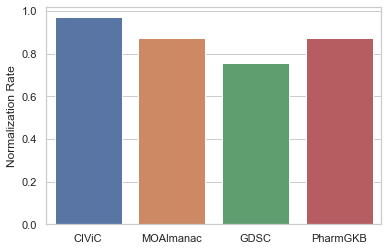

In [12]:
import pandas as pd

norm_results = pd.DataFrame(
    [civic_normalization_rate, moa_normalization_rate, gdsc_normalization_rate, pharmgkb_normalization_rate], 
    index=["CIViC", "MOAlmanac", "GDSC", "PharmGKB"],
    columns=["Normalization Rate"]
)

import seaborn as sns
sns.reset_orig()
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=norm_results.index, y="Normalization Rate", data=norm_results)
ax.figure.savefig('output_figure.png',dpi=600)